An emcee sampler notebook, testing various things about the emcee package.

# Study

In [10]:
import numpy as np
import emcee
import gp_sandbox as cgp
import pandas as pd
import george
import scipy.stats
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
%matplotlib inline

def sample(days=1):
    """Samples the number of points from the provided lightcurve at a specified cadence.
    The total simulated light curve has around 400,000 points.
    
    Input: cap of points of simulated data to sample.
    Output: x, y, and yerr info about points sampled.
    """
    cap = 2880 * days
    
    df = pd.read_csv('3200_lc_49627_to_49787.txt', delimiter=' ',header=None, names=['x','y'], dtype={'x':float, 'y':float})
    pre_x = df.x
    pre_y = df.y

    data_x, data_y, yerr = cgp.sample_data(pre_x[0:cap], pre_y[0:cap], yerr_amp=0.2, cadence_n=1)
    
    #plot the original points
    plt.figure(figsize=(10, 7))
    plt.plot(pre_x[0:cap], pre_y[0:cap],  '-', alpha=0.5, label="Original")
    plt.plot(data_x,data_y, 'ko', ms = 3, alpha=0.5, label="Sample")
    
    return data_x, data_y, yerr


def prior(params):
    """Calculated the log of the prior values, given parameter values:
    param[0] : mean (between 0 and 2)
    param[1] : log amplitude (between -10 and 10)
    param[2] : gamma (log gamma between 0.1 and 100)
    param[3] : log period (period between 1h and 24hrs)
    
    Input: list of param values
    Output: sum of all log priors (-inf if a parameter is out of range)"""

    p_mean = scipy.stats.uniform(0,2).logpdf(params[0])
    p_log_amp = scipy.stats.uniform(-10,20).logpdf(params[1])  
    p_log_gamma = scipy.stats.uniform(np.log(0.1), np.log(10)*3).logpdf(np.log(params[2]))
    p_period = scipy.stats.uniform(np.log(1./24), -np.log(1./24)).logpdf((params[3]))
        
    sum_log_prior =  p_mean + p_log_amp + p_log_gamma + p_period
    if np.isnan(sum_log_prior) == True:
        return -np.inf
    
    return sum_log_prior


def post_lnlikelihood(params):
    """Calculates the log prior and likelihood. 
    Returns the posterior unless the posterior is infinite."""    
    log_prior = prior(params)
    
    if np.isneginf(log_prior) == True:
        return -np.inf
    
    gp.set_parameter_vector(params)
    gp.compute(x, yerr)
    ln_likelihood = gp.lnlikelihood(y)+log_prior
    
    print(ln_likelihood)
    return ln_likelihood if np.isfinite(ln_likelihood) else -1e25




def optimize(x, y, yerr, gp, print_results = True):
    """Optimizes current parameters by using the current parameters, and x and y values."""
    gp.compute(x, yerr)

    from scipy.optimize import minimize

    def neg_ln_like(p):
        gp.set_parameter_vector(p)
        try:
            negloglike =  -gp.log_likelihood(y)
            return negloglike
        except scipy.linalg.LinAlgError:
            return np.inf


    def grad_neg_ln_like(p):
        gp.set_parameter_vector(p)
        try:
            grad_loglike =  -gp.grad_log_likelihood(y)
            return grad_loglike
        except scipy.linalg.LinAlgError:
            return np.inf

    result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)#, method='L-BFGS-B')
    
    return result



def walker_params(params, cov_scale=1):
    """Sets up the initial parameters for all the walkers.
    Uses optimized parameter values as starting values.
    Function generates a scattered gaussian distribuation of starting parameter values.
    Scatter determined by the cov_scale.
    
    Returns the inital walker parameters and the gp class."""
    mean, log_amp, gamma, log_period = params
    amp = np.exp(log_amp)

    kernel = amp * george.kernels.ExpSine2Kernel(gamma = gamma, log_period = log_period)
    gp = george.GP(kernel, fit_mean=True, mean=mean)
    
    result = optimize(x, y, yerr, gp)
    p0 = np.random.multivariate_normal(mean=result.x, cov=cov_scale*result.hess_inv, size=nwalkers)
    return p0, gp


      fun: -84.65235569324022
 hess_inv: array([[  5.59035352e-04,  -9.48763654e-05,  -4.48949259e-04,
         -1.51729010e-08],
       [ -9.48763654e-05,   6.04300151e-02,  -5.55226716e-01,
          7.53805828e-08],
       [ -4.48949259e-04,  -5.55226716e-01,   2.23810035e+01,
         -2.44834786e-07],
       [ -1.51729010e-08,   7.53805828e-08,  -2.44834786e-07,
          3.91549558e-10]])
      jac: array([ -1.71530701e-09,   3.64033895e-07,  -7.22703764e-09,
         3.02810222e-04])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 72
      nit: 20
     njev: 61
   status: 2
  success: False
        x: array([  0.99695021,  -4.89182595,  59.08358087,  -1.89602692])


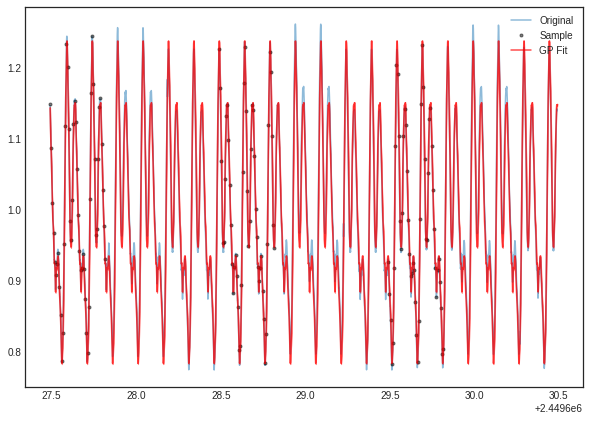

77.6108639308
77.6929227218
77.2925455659
77.6281590784
77.7159536905
77.712223684
77.8424053447
77.470624979
77.7143504835
77.3818724249
77.8082496558
77.8131752744
77.817362146
77.7445783566
77.7556266856
77.6214588768
77.8037515669
77.8039162985
77.8173610147
77.6665444604
77.7990500161
77.8166084637
77.7943155789
77.8519683676
77.4729116527
77.8209357607
77.6770371331
77.7278078186
77.730730345
77.8341098048
77.8193546806
77.7634096852
77.677669311
77.8250500021
77.2974516953
77.7422457731
77.6865877418
77.6951086263
77.6018911556
77.4495649294
77.6351994183
77.5774125343
77.7049313919
77.8002934958
77.6987198582
77.7655574294
77.8401698782
77.7744188113
77.7582047183
77.7358040372
77.6557135468
77.5346028255
77.4237854595
77.7575947336
77.820944339
77.6585044055
77.6435586101
77.8194931369
77.7245418098
77.8107104031
77.7027062938
77.7421111957
77.5394949657
77.6162283587
77.6117987325
77.7041882363
77.5859665612
77.7232288786
77.7155147637
77.7831319799
77.6852098278
77.585166982

76.6479241889
76.8077759014
77.423053511
76.9585008342
71.6385039713
77.8148962275
76.6215778105
77.6995251475
73.5154624887
74.4521330926
77.3562441745
70.0280099735
77.5117721648
75.4139893372
77.8031386433
75.8108445489
77.7150091379
75.3806126688
77.2222027769
77.4719798273
75.068623683
77.2861001382
74.0991311406
67.896867301
76.4209026415
77.7415929186
75.6402588291
73.525947997
77.0868281217
77.6700867142
77.8170066495
71.6256676137
75.8285153754
77.1290882467
76.8122823561
77.5238691715
76.9051675337
77.2568987475
75.2995728117
77.8329580665
77.3532013991
73.8783184161
77.7294573569
76.7793354669
77.6355140495
73.9268464702
73.9864797419
77.2856033559
76.9983845639
75.418604426
77.8234530524
77.4413175984
71.6630983026
76.7448646656
77.6937719293
75.1043526313
77.0413044574
77.0556975205
77.7067136307
77.5744471946
77.5967107117
77.4962965708
77.6931305308
75.2129067211
74.688548503
77.645075004
77.0884422631
76.0948183711
77.6562457215
75.921609303
74.4937230879
71.2345942758


76.5933987256
77.035521808
70.0713085368
74.0109625904
76.2126965758
75.8537574169
76.005763363
75.7206817126
77.0005913848
76.7028485951
74.1754072195
77.5742403007
65.8615589824
76.807570092
67.7349796348
77.0103463916
74.0057770541
77.5282680418
75.3206084968
75.7435061815
76.9915411876
75.4171747933
76.5275305471
76.2505661291
70.9394267837
69.2909965581
77.4945721531
75.0223169029
75.4621639906
75.1763594935
75.0114889755
77.4945033685
75.9198052584
73.8439856097
70.0772257472
74.9019784717
70.7402354148
75.6172859049
77.2927703128
75.5928978306
75.350599043
76.5195302311
76.9069044024
76.1828731172
71.7625068916
77.1963781711
75.8695775443
76.3887587672
77.0534479175
75.1494294852
70.2277161326
73.8331733333
77.0719128174
73.9150212407
76.0636997577
76.9980896521
70.9534380331
76.6389807459
76.2154722334
77.5144236655
69.3627927353
77.2402112628
69.8897232071
75.3928940151
76.3801196687
76.0080378213
76.5549484978
77.348171841
75.8643245395
76.5304310346
75.7821441918
77.08268172

77.0842766742
75.4252862538
77.1181664101
76.5689099079
76.7562958909
75.9800482938
77.1249539041
74.879681151
75.2904541643
76.461737499
76.3367293711
72.8616626805
68.2899347821
71.3841170576
61.364726388
77.0326891209
76.784559674
76.4053046699
73.3520220984
76.4583875783
75.619236647
76.6910247855
76.8623995291
73.7232231426
77.5673984527
69.3167614224
76.8691627538
76.0722918694
72.6020208829
75.7438195337
74.1797705561
69.8445884305
75.8485139572
76.9315626832
62.6561090345
56.5701932735
71.7716359183
77.1559562386
76.5023010596
76.5196911949
77.404364953
73.5124716565
72.9005382636
65.9489902758
69.5199511832
74.4290153932
75.3872540175
76.1262124207
77.0402284951
76.2143408116
77.7054164505
77.2054094073
76.409478976
76.1909609463
76.373799403
77.1701805441
77.499885196
75.7823004794
76.9418516101
75.5875898617
75.8744143639
76.6115623271
54.0583612392
75.3176052331
75.2697517137
65.4380902879
75.8983375664
76.2995462042
73.6637164855
76.8756931835
75.2571259983
73.3472867898
7

In [55]:
ndim, nwalkers = 4, 100
days = 3
x, y, yerr = sample(days)

###initialize walker parameters
params = [np.mean(y), 0, 1, -1.9]
p0, gp = walker_params(params=params, cov_scale=0.1)


#plot the 
#print("params: " + str(gp.get_parameter_vector()))
x_possible = np.linspace(x.iloc[0],x.iloc[0]+days, 2880*days)
pred, pred_var = gp.predict(y, x_possible, return_var=True)
plt.fill_between(x_possible, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="red", alpha=0.4)
plt.plot(x_possible, pred, "red", lw=1.5, alpha=0.7, label = "GP Fit")
plt.legend()
plt.show()

sampler = emcee.EnsembleSampler(nwalkers, ndim, post_lnlikelihood, threads=2)

In [56]:
%%time
sampler.run_mcmc(p0, 20)

CPU times: user 923 ms, sys: 525 ms, total: 1.45 s
Wall time: 19.1 s


(array([[  0.95323582,  -5.02706373,  68.32297492,  -1.8960139 ],
        [  0.95917164,  -4.88294882,  58.09629431,  -1.8959952 ],
        [  1.00263184,  -5.33352777,  70.1684369 ,  -1.89599892],
        [  1.00765304,  -4.44343055,  51.72305862,  -1.89602533],
        [  1.02898692,  -4.52667372,  58.03371402,  -1.8960303 ],
        [  0.99327768,  -5.07433541,  60.71520095,  -1.89602447],
        [  1.03913627,  -5.14211207,  61.29193821,  -1.89601426],
        [  0.94851026,  -5.00213202,  69.7118227 ,  -1.89602727],
        [  0.97974343,  -5.07638883,  57.59374285,  -1.89604223],
        [  0.97520058,  -5.19457044,  70.37896038,  -1.89604235],
        [  1.02852992,  -4.82026227,  59.60583981,  -1.89600181],
        [  0.98148966,  -4.94636095,  69.2116144 ,  -1.89603616],
        [  0.99274983,  -4.76125995,  75.39632181,  -1.89598542],
        [  0.96467589,  -4.1712974 ,  49.44128725,  -1.89602746],
        [  0.98942563,  -4.50770665,  52.0057786 ,  -1.89601268],
        [ 

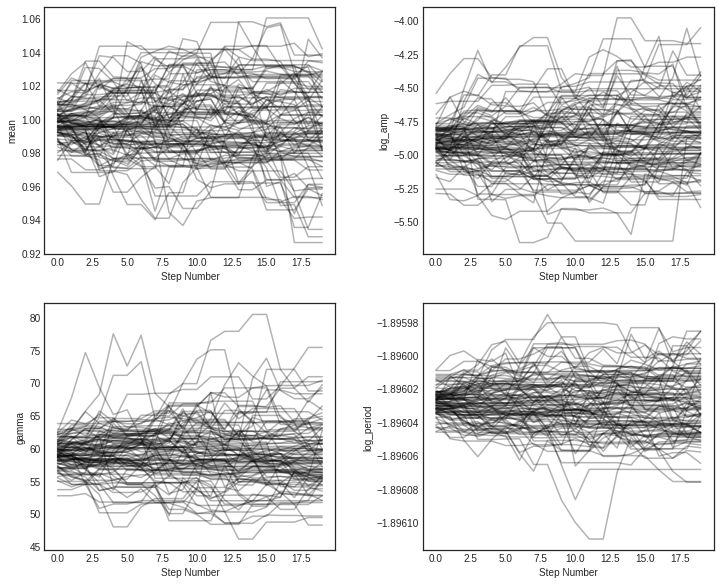

In [60]:
fig, ax = plt.subplots(2,2, figsize =(12,10))
fig.subplots_adjust(wspace=0.3)

dims = ['mean', 'log_amp', 'gamma', 'log_period']
x = np.arange(sampler.iterations)

axs = [ax[0,0], ax[0,1], ax[1,0], ax[1,1]]

for i in range(ndim):
    axs[i].set_xlabel('Step Number')
    axs[i].set_ylabel('{}'.format(dims[i]))
    for j in range(nwalkers):
        param = sampler.chain[j,:,i]
        axs[i].plot(x, param, 'k-', alpha=0.3)


Mean acceptance fraction: 0.628


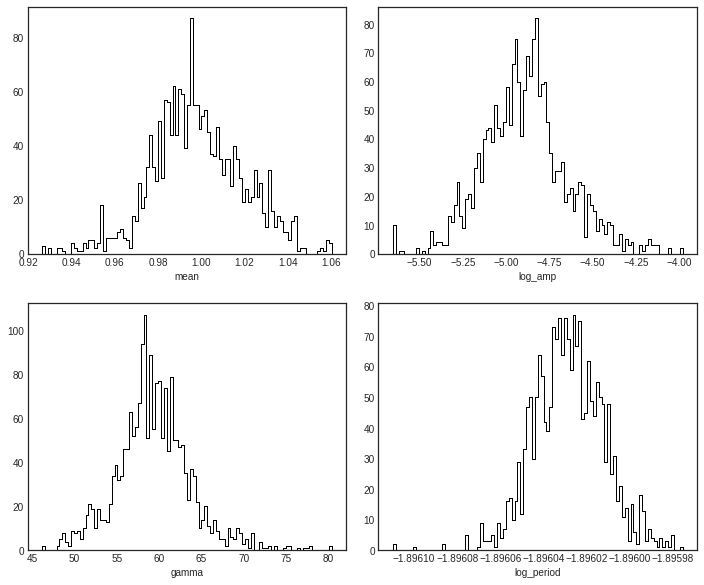

In [62]:
fig, ax = plt.subplots(2,2, figsize =(12,10))
fig.subplots_adjust(wspace=0.1)

dims = ['mean', 'log_amp', 'gamma', 'log_period']
axs = [ax[0,0], ax[0,1], ax[1,0], ax[1,1]]

for i in range(ndim):
    axs[i].set_xlabel('{}'.format(dims[i]))
    for j in range(nwalkers):
        param = sampler.chain[j,:,i]
        axs[i].hist(sampler.flatchain[:,i], 100, color="k", histtype="step")

print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

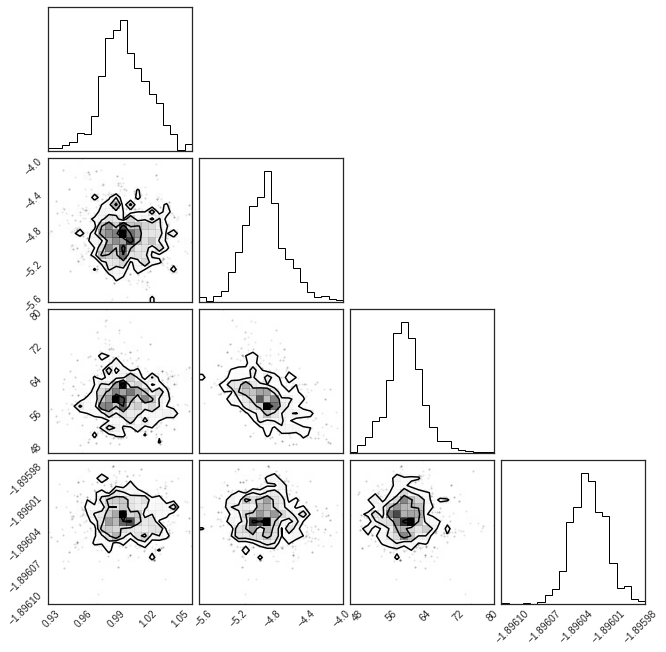

In [63]:
import corner
samples = sampler.chain[:, 1:, :].reshape((-1, ndim))
fig = corner.corner(samples)